# Diffusion Model

## DM from scratch

DM consists of 2 parts: forward pass and denoising part. 
In the forward pass, a small amount of guassian noise was added progressively at each step. The amount of noise and number of steps were chosen arbitrarily and were managed by a scheduler.
In the backward pass, the noise was estimated using a neural network model and removed from the image of the each step. The result was obtained by exhausting all steps.
DM gained popularity for generating realistic and diversified images for its easiness for training compared to GAN models. 

The training was done using GPU using NVIDIA GeForce RTX 3090 with CUDA Version 12.3.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import torch.utils.data as utils
import torchsummary

import diffusers

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ", device)

using device:  cuda:0


## Data preparation
### use MNIST dataset

In [3]:
data_transforms = [
    transforms.ToTensor(), # convert to the range [0,1]
    transforms.Lambda(lambda x: x * 2 - 1) # convert to the range [-1,1]
]
data_transforms = transforms.Compose(data_transforms)
data = datasets.MNIST("./mnist", download=False, transform=data_transforms)

In [4]:
batch_size = 1200

# dataloaders
train_loader = utils.DataLoader(dataset=data, batch_size=batch_size)
valid_loader = utils.DataLoader(dataset=data, batch_size=batch_size)

print("there are :", len(train_loader), "batches")

there are : 50 batches


## Forward pass

It is supposed that the noise follows the normal distribution:

$q(x_t|x_0) = N (x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I)$

The noise adding process is markov chain:

$q(x_{1:T}|x_0) = \prod q(x_t|x_{t-1})$


Based on the above equations, the subsequent image is calculated by

$ x_t= \sqrt{\bar{\alpha}_t} x_0 + \sqrt{(1-\bar{\alpha}_t)} \epsilon_t$

where\
$\alpha_t = 1 - \beta_t$\
$\bar{\alpha}_t = \displaystyle \prod_{s=1}^{t} \alpha_s$

### Scheduler
I use a linear scheduler in the range $\beta_t \in [0.0001, 0.02]$ as mentioned the article.

In [5]:
# linear scheduling
def betaLinScheduler(timeSteps, betaStart=0.0001, betaEnd=0.02) :
    # return a list of t
    betas = torch.linspace(betaStart, betaEnd, timeSteps) # (timeSteps,)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, axis=0)
    
    return betas, alphas, alphas_bar

### test
print(betaLinScheduler(200)[2].shape)

torch.Size([200])


The cosine beta was calculated using:

$ \bar{\alpha}_t = \frac{f(t)}{f(0)}$

with

$ f(t) = cos(\frac{t/T + s}{1 + s} * \frac{\pi}{2})^2$

And the beta was computed by:

$ \beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t - 1}}$

In [6]:
# cosin scheduler
def betaCosinScheduler(timeSteps, s = 0.008) :

    t = torch.arange(0, timeSteps+1)
    alpha_cumprod = torch.cos((t/timeSteps + s) / (1 + s) * torch.pi / 2) ** 2
    alpha_cumprod = alpha_cumprod / (np.cos(s / (1 + s) * torch.pi / 2) ** 2)
    beta_t = (1 - alpha_cumprod[1:] / alpha_cumprod [:-1])

    beta_t = torch.clip(beta_t, 0.0001, 0.999)

    alpha_t = (1.0 - beta_t)
    alpha_bar_t = (torch.cumprod(alpha_t, axis=0))
    
    return beta_t, alpha_t, alpha_bar_t

### test
print(betaCosinScheduler(200)[2].shape)

torch.Size([200])


In [7]:
# pre-calculated parameters

param_timesteps = 200
param_beta, param_alpha, param_alpha_bar = betaLinScheduler(param_timesteps)
#beta, alpha, alpha_bar = betaCosinScheduler(timesteps)
param_sqrt_alpha_bar = torch.sqrt(param_alpha_bar)
param_alpha_bar_prev = F.pad(param_alpha_bar[0:-1], (1,0), value=1.0)
param_sqrt_alpha_inv = torch.sqrt(1.0 / param_alpha)
param_sqrt_alpha_bar_inv = torch.sqrt(1.0 / param_alpha_bar)
param_sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - param_alpha_bar)
param_posterior_variance = param_beta * (1.0 - param_alpha_bar_prev) / (1.0 - param_alpha_bar)

param_beta = param_beta.to(device)
param_alpha = param_alpha.to(device)
param_alpha_bar = param_alpha_bar.to(device)
param_sqrt_alpha_bar = param_sqrt_alpha_bar.to(device)
param_alpha_bar_prev = param_alpha_bar_prev.to(device)
param_sqrt_alpha_inv = param_sqrt_alpha_inv.to(device)
param_sqrt_alpha_bar_inv = param_sqrt_alpha_bar_inv.to(device)
param_sqrt_one_minus_alpha_bar = param_sqrt_one_minus_alpha_bar.to(device)
param_posterior_variance = param_posterior_variance.to(device)

In [8]:
# helper functions

def getParam(params, t, x_shape):
    
    vals = torch.gather(params, 0, t)
    
    return vals.reshape((len(t), x_shape[1], 1, -1)) # output shape (batch, 1, 1, 1)


def forwardDiffusionSample(x0, t) :
    # t has size(batch, )
    
    # noise size (batch, channel, width, height)
    standardNoise = torch.randn(*x0.shape).to(device) # standard noise with mean=0 and variance=1
    
    sqrt_alpha_bar_t = getParam(param_sqrt_alpha_bar, t, x0.shape)
    
    sqrt_one_minus_alpha_bar_t = getParam(param_sqrt_one_minus_alpha_bar, t, x0.shape)
    
    # output mean + variance * noise - reparametrization trick
    # tuple of size(batch, channel, w, h)
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * standardNoise, standardNoise #(batch, channel, width, height)

## test
x0 = torch.rand((10, 1, 28 ,28)).to(device)
t = torch.randint(0, 200, (10,)).to(device)
print(forwardDiffusionSample(x0, t)[0].size())

torch.Size([10, 1, 28, 28])


torch.Size([1200, 1, 28, 28])


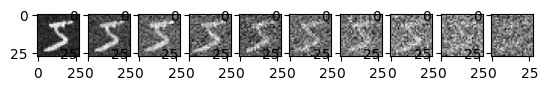

In [9]:
# to illustrate the effect of forward pass - noise adding process
imgs = next(iter(train_loader))[0]
print(imgs.shape)
num_img = 10
fig, axs = plt.subplots(1, num_img)
step = param_timesteps//num_img
i = 0
for t in range(0, param_timesteps):
    if (t+1)%step == 0:
        im, noises = forwardDiffusionSample(imgs[:1].to(device), torch.tensor([t]).to(device))

        axs[i].imshow(im[0][0].cpu(), cmap='gray')
        i += 1


### Time Embedding



To include the information about the step, an embedding technique was used. This technique was used in the tranformer models and proved effective.
For me, the embedding represent the orginal value by a combination of a series of sinusoidal values and the resulting embeddings are the coefficient values.

In [10]:
# position embedding object

class PosEmbed(nn.Module) :

    def __init__(self, dim, n=10000) :
        
        super().__init__()
        self.dim = dim
        self.n = n

    @staticmethod
    def posEmbedding(t, size, n=10000):
        # size is the total mebedding unit number, with each unit denoted by ind i
        # t has size (batch, 1)
        embeds = torch.zeros((t.shape[0], size)).to(device) # size (batch, size)
        
        pe = torch.tensor([1/(n**(2*i/size)) for i in range(0,size,2)]).to(device)
        
        for i, pos in enumerate(t):
            embeds[i, 0: :2] = torch.sin(pos / pe)
            embeds[i, 1: :2] = torch.cos(pos / pe)
        
        return embeds

    def forward(self, x) :
        return self.posEmbedding(x, self.dim, self.n).requires_grad_(False)

## test
m = PosEmbed(200).to(device)
x = torch.randint(0, 200, (10,)).to(device)
print(m(x).shape)

torch.Size([10, 200])


## Sampling process

Bases on the long and complicated calculations in the article, the image of the previous step can be calculated:

$ x_{t-1} = \frac{1}{\sqrt{\bar{\alpha}_t}} (x_t - \frac{\beta_t}{\sqrt{(1-\bar{\alpha}_t)}} * \epsilon_\theta(x_t, t)) + \sigma_t * z  $

where 

$ \sigma_t^2 = \beta_t * \frac{(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}$

And the loss functions is:

$ L = || \epsilon_t - \epsilon_\theta (\sqrt{\bar{\alpha}_t} x_0 + \sqrt{\bar{\beta}_t} * \epsilon, t)||^2$
which is only the MSE of the data difference (eg Image values).

To get the generative results at the end, we need to train forst a Unet to predict the noise values for the backward process. Then we use the sampling method to generate images from some noises. 

In [37]:
# sampling

@torch.no_grad()
def sampling(model, label):
    #print("timesteps: ", timesteps)
    
    # sampling noise
    x = torch.randn((1, 1, 28, 28)).to(device)

    img_num = 10
    img_step = int(np.ceil(param_timesteps / img_num))
    
    fig, axs = plt.subplots(1,img_num, figsize=(16, 16), tight_layout=True)
    
    im = 0
    
    #label = torch.randint(0, 10, (x.shape[0],))
    #print("generating num: ", label)
    # loop
    for i in range(param_timesteps)[::-1]:
        
        z = torch.randn((1, 1, 28, 28)).to(device)
        
        t = torch.tensor([i]).to(device)
        
        beta_t = getParam(param_beta, t, x.shape)
        sqrt_alpha_inv_t = getParam(param_sqrt_alpha_inv, t, x.shape)
        sqrt_one_minus_alpha_bar_t = getParam(param_sqrt_one_minus_alpha_bar, t, x.shape)
        posterior_variance_t = getParam(param_posterior_variance, t, x.shape)
        
        if i > 0:
            x = sqrt_alpha_inv_t * (x - beta_t * model(x, t) / sqrt_one_minus_alpha_bar_t) + torch.sqrt(posterior_variance_t) * z
        else:
            x = sqrt_alpha_inv_t * (x - beta_t * model(x, t) / sqrt_one_minus_alpha_bar_t)
            
        #print(x.shape)
        #x = torch.clamp(x, -1.0, 1.0)
        if i % img_step == 0:
           
            axs[im].imshow(x[0][0].cpu(), cmap='gray')
            axs[im].axis("off")
            im += 1

    return x

## test
if False:
    img = sampling(dm, 1)

Here I used a simplest form of unet for nosie prediction. It has only one one bloc consisting of 3 layers of conv2D. No skip connections were added either. 

In [12]:
# unet
class BlockConv(nn.Module):
    
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        if up:
            self.conv1 = nn.Conv2d(in_ch*2, out_ch, 3, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        
        self.gnorm1 = nn.GroupNorm(16, out_ch)
        self.gnorm2 = nn.GroupNorm(16, out_ch)
        
        self.act = nn.SiLU()
    
    def forward(self, x, te):
        
        # conv layer
        h = self.gnorm1(self.act(self.conv1(x)))
        
        # Time embedding
        time_emb = self.act(self.time_mlp(te))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        
        # Add time channel
        h = h + time_emb
        
        # conv layer
        h = self.gnorm2(self.act(self.conv2(h)))
        
        return h
        

class BlockTrans(nn.Module):
    
    def __init__(self, out_ch, up=False):
        
        super().__init__()
        
        if up:
            self.transform = nn.ConvTranspose2d(out_ch, int(out_ch/2), 4, 2, 1)
        else:
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.dropout = nn.Dropout(0.1)

        
    def forward(self, x):

        # Down or Upsample
        h = self.transform(x)
        
        return self.dropout(h)


class Unet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (16, 32, 64)
        up_channels = (64, 32, 16)
        out_dim = 1 
        time_emb_dim = 200

        # Time embedding
        """
        self.time_embed = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                #nn.Linear(time_emb_dim, time_emb_dim),
                #nn.SiLU()
            )
        """
        self.time_embed = nn.Sequential(
            PosEmbed(time_emb_dim).to(torch.float32), # (batch, embed_dim)
            nn.Linear(time_emb_dim, time_emb_dim), # (batch, out_ch)
            nn.SiLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.inact = nn.SiLU()
        self.innorm = nn.GroupNorm(16, up_channels[-1])

        # Downsample
        
        self.convdowns = nn.ModuleList([BlockConv(down_channels[0], down_channels[0], time_emb_dim)])
        self.convdowns.extend(nn.ModuleList([BlockConv(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)]))
        self.downs = nn.ModuleList([BlockTrans(down_channels[i]) for i in range(len(down_channels)-1)])
        
        # Upsample
        self.convups = nn.ModuleList([BlockConv(up_channels[i], up_channels[i], time_emb_dim, up=True) for i in range(len(up_channels))])
        self.ups = nn.ModuleList([BlockTrans(up_channels[i], up=True) for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)

        self.middle = nn.Conv2d(down_channels[-1], down_channels[-1]*2, 4,2,1)
        
        self.outconv = nn.Conv2d(up_channels[-1], out_dim, 1)
        self.outact = nn.SiLU()
        self.outnorm = nn.GroupNorm(16, up_channels[-1])

    def forward(self, x, t, l=None):
        # Embedd time
        te = self.time_embed(t)
        # Initial conv
        x = self.innorm(self.inact(self.conv0(x)))
        # Unet
        residual_inputs = []
        i = 0
        for down in self.convdowns:

            x = down(x, te)
            
            residual_inputs.append(x)
            if (i<len(self.downs)):
                x = self.downs[i](x)

            i = i+1

        j = 0
        for up in self.convups:
            
            # Add residual x as additional channels
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)

            # conv layers - down channels
            
            x = up(x, te)

            # upsample
            if (j<len(self.ups)):
                x = self.ups[j](x)
            j = j+1

        # out
        x = self.outact(self.outnorm(x))
        x = self.outconv(x)
        return x

if False:
    m = Unet().to(device)
    #m
    #print(sum(p.numel() for p in m.parameters()))
    x = torch.rand(10, 1, 28, 28).to(device)
    t = torch.randint(0, 200, (10,)).to(device)
    print(m(x, t).shape)

1 / 50 : loss: 0.19715365767478943
2 / 50 : loss: 0.09448180347681046
3 / 50 : loss: 0.08250796794891357
4 / 50 : loss: 0.07501591742038727
5 / 50 : loss: 0.07056596130132675
6 / 50 : loss: 0.06729280203580856
7 / 50 : loss: 0.06396366655826569
8 / 50 : loss: 0.06166325509548187
9 / 50 : loss: 0.0602874793112278
10 / 50 : loss: 0.059312209486961365
11 / 50 : loss: 0.057594094425439835
12 / 50 : loss: 0.05667312070727348
13 / 50 : loss: 0.05630817636847496
14 / 50 : loss: 0.05590158700942993
15 / 50 : loss: 0.05520062893629074
16 / 50 : loss: 0.05431656166911125
17 / 50 : loss: 0.054387520998716354
18 / 50 : loss: 0.05401941016316414
19 / 50 : loss: 0.053285498172044754
20 / 50 : loss: 0.05322568118572235
21 / 50 : loss: 0.05248349532485008
22 / 50 : loss: 0.05227464437484741
23 / 50 : loss: 0.0521995835006237
24 / 50 : loss: 0.05207590013742447
25 / 50 : loss: 0.05173157900571823
26 / 50 : loss: 0.051389653235673904
27 / 50 : loss: 0.05118272826075554
28 / 50 : loss: 0.0512364991009235

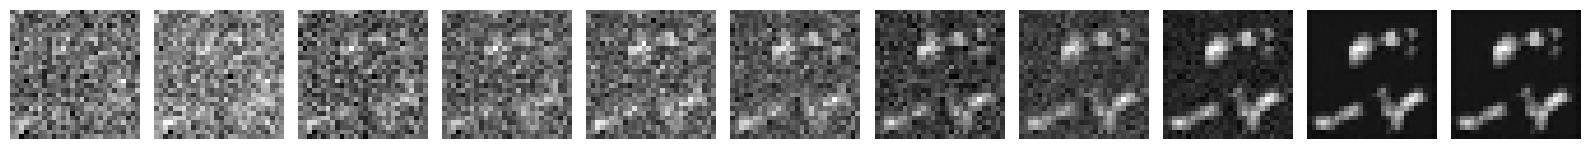

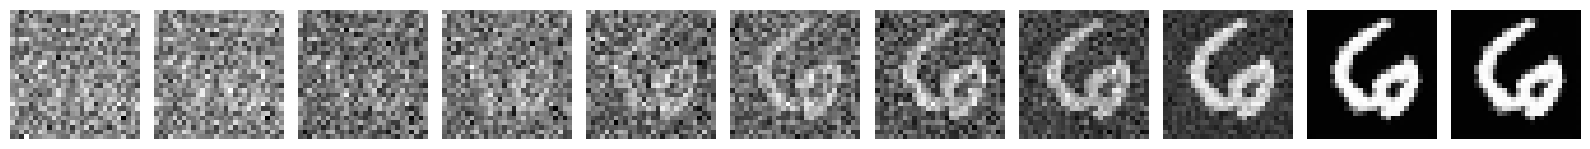

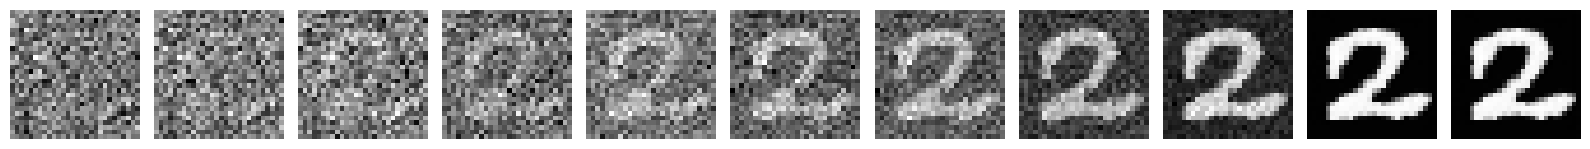

In [13]:
 # training
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("using device: ", device)

# log losses for plotting
losses = []

# model
dm  = Unet().to(device)

# loss function
loss_fn = nn.MSELoss()
    
lr = 0.01
optimizer = torch.optim.Adam(dm.parameters(), lr=lr)

epochs = 50

for e in range(epochs) :
    
    loss_epoch = 0
    loss_num = 0
    
    for batch in train_loader:
        
        # batch[0] contains images, batch[1] contains labels

        # ramdom get t 
        ts = torch.randint(0, param_timesteps, (batch[0].shape[0],)).to(device)

        # get image
        im_data = batch[0].to(device)

        # generate noised image at t
        ims, noises = forwardDiffusionSample(im_data, ts)
        
        ls = batch[1]

        preds_noise = dm(ims.to(torch.float32), ts.to(torch.float32))

        loss = loss_fn(noises, preds_noise)

        loss_num += len(batch)
        
        loss_epoch += loss * len(batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('{} / {} : loss: {}'.format(e+1, epochs, loss_epoch/loss_num))
    
    losses.append(loss_epoch/loss_num) # log losses

    # show some results
    if (e%20 == 0) :
        label = torch.randint(0, 10, (1,))
        img = sampling(dm, label)

     

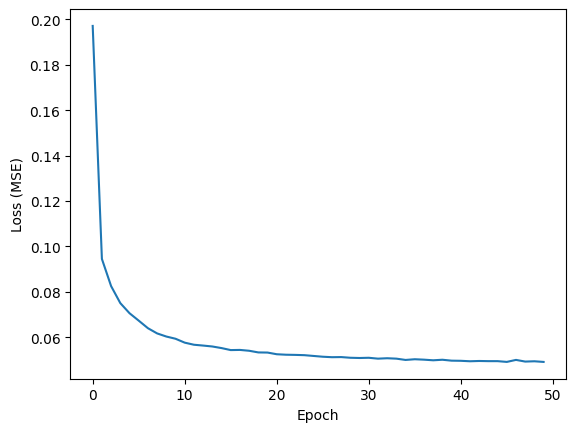

In [25]:
losses = [i.detach().cpu().numpy() for i in losses]
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.show()

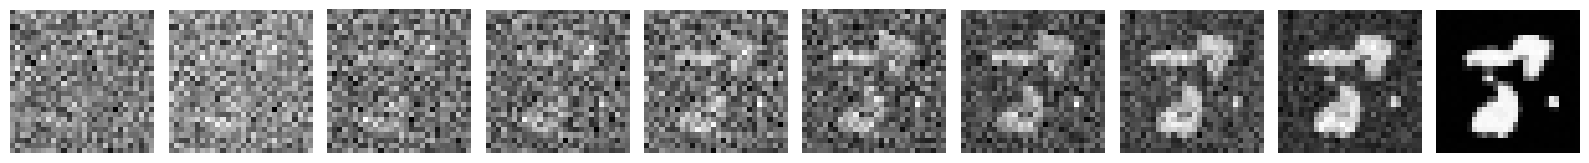

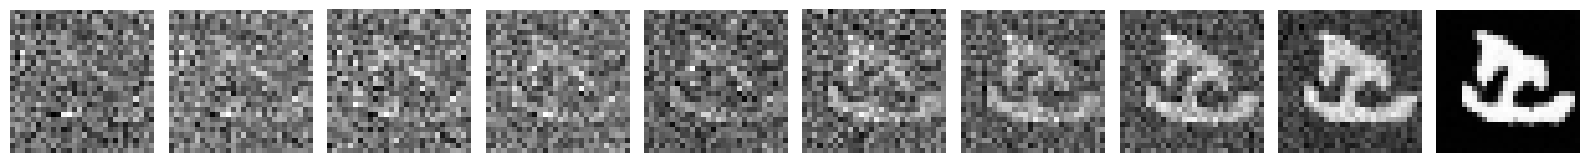

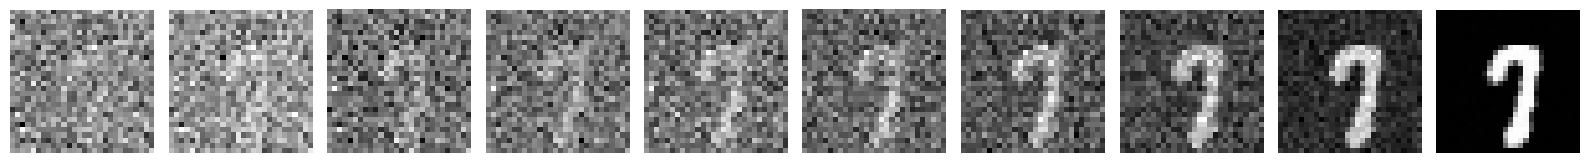

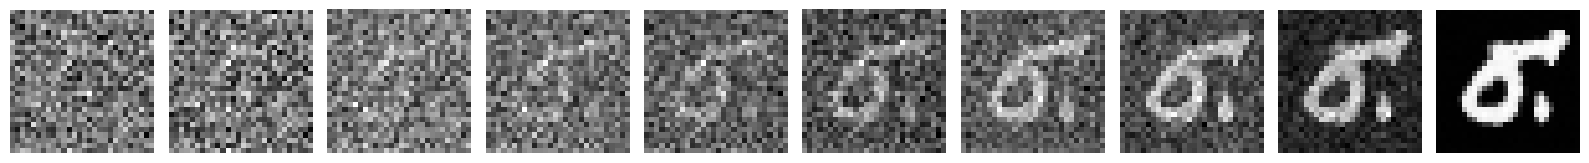

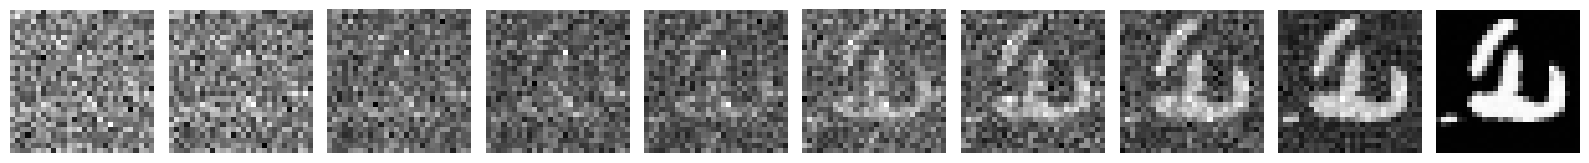

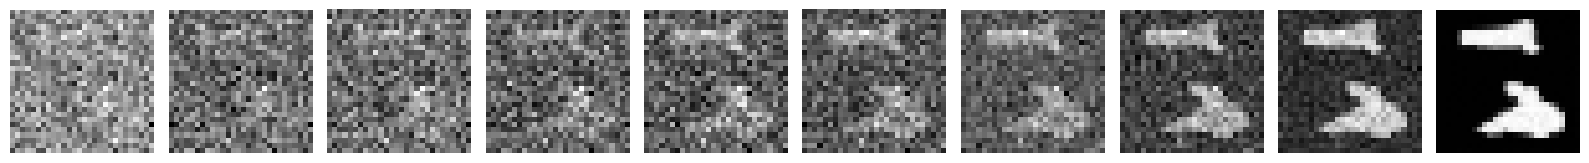

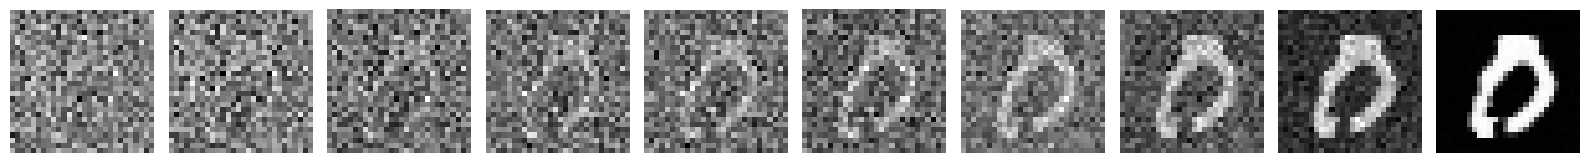

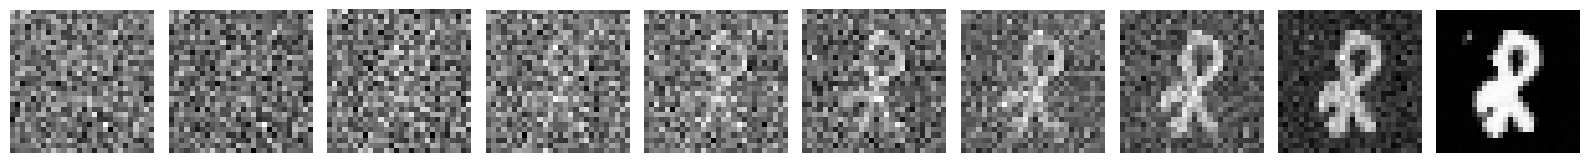

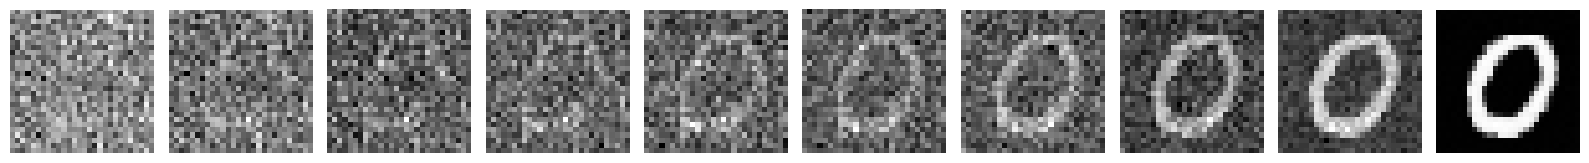

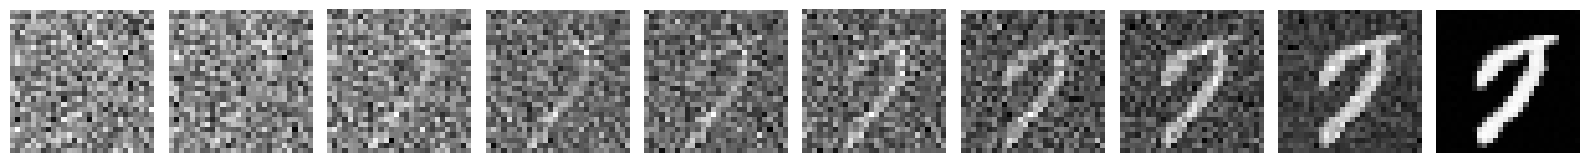

In [39]:
# results after training
for i in range(10):
    img = sampling(dm, 1)

## DM from HuggingFace

Hugging Face provide an python API with ready-to-use diffusion models with modular parts and pretrained weights. I used it to validate the results obtained from my model from scratch.

In [27]:
# load Unet structure without pretrained weights
model_hf = diffusers.UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    norm_num_groups =16,
    block_out_channels=(16,32,64),
    down_block_types=(

        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(

        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model = model_hf

In [28]:
# linear scheduler
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200)

In [35]:
@torch.no_grad()
def sample_hf(model, scheduler) :
    
    #scheduler.set_timesteps(200)

    img_num = 10
    img_step = int(np.ceil(max(scheduler.timesteps) / img_num))

    
    fig, axs = plt.subplots(1,img_num, figsize=(16, 16), tight_layout=True)
    
    im = 0
    
    x = torch.randn((1, 1, 28, 28)).to(device)

    for t in scheduler.timesteps :
        
        out = model(x, t)['sample']

        x = scheduler.step(out, int(t), x, generator=None)['prev_sample']

        if int(t) % img_step == 0:
            axs[im].imshow(x[0][0].cpu(), cmap='gray')
            axs[im].axis("off")
            im += 1    
    #return torchvision.transforms.ToPILImage()(image.squeeze(0)) 

# sample_hf(model_hf,noise_scheduler)

1 / 50 : loss: 0.17037859559059143
2 / 50 : loss: 0.11804425716400146
3 / 50 : loss: 0.09122607856988907
4 / 50 : loss: 0.08461856096982956
5 / 50 : loss: 0.08228662610054016
6 / 50 : loss: 0.07924200594425201
7 / 50 : loss: 0.0714121013879776
8 / 50 : loss: 0.07027807831764221
9 / 50 : loss: 0.06988672912120819
10 / 50 : loss: 0.06576431542634964
11 / 50 : loss: 0.06568867713212967
12 / 50 : loss: 0.061614252626895905
13 / 50 : loss: 0.060299139469861984
14 / 50 : loss: 0.06132698804140091
15 / 50 : loss: 0.06145498901605606
16 / 50 : loss: 0.05896150693297386
17 / 50 : loss: 0.05533509701490402
18 / 50 : loss: 0.05830717086791992
19 / 50 : loss: 0.05627021566033363
20 / 50 : loss: 0.054905906319618225
21 / 50 : loss: 0.055035922676324844
22 / 50 : loss: 0.054902005940675735
23 / 50 : loss: 0.05468315631151199
24 / 50 : loss: 0.05346377566456795
25 / 50 : loss: 0.05493972823023796
26 / 50 : loss: 0.05279102921485901
27 / 50 : loss: 0.05246010050177574
28 / 50 : loss: 0.053751330822706

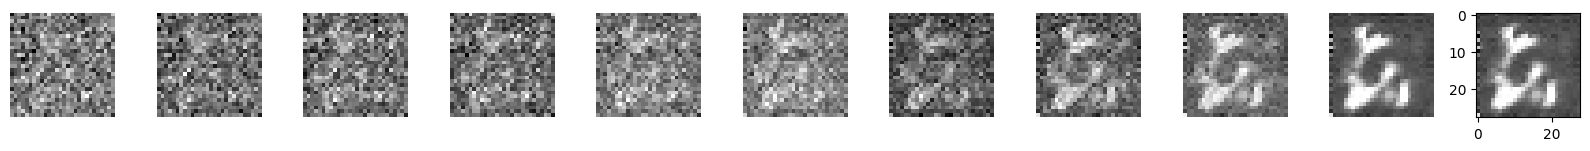

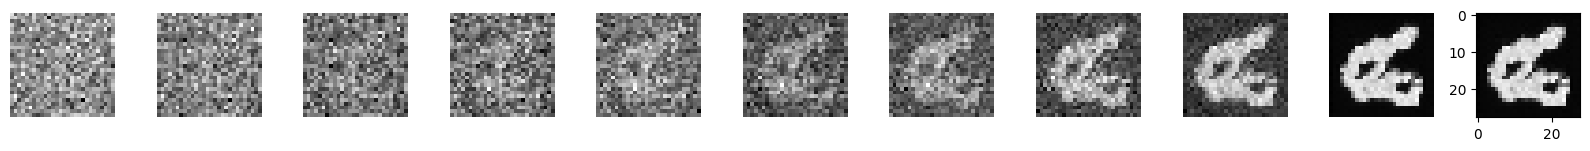

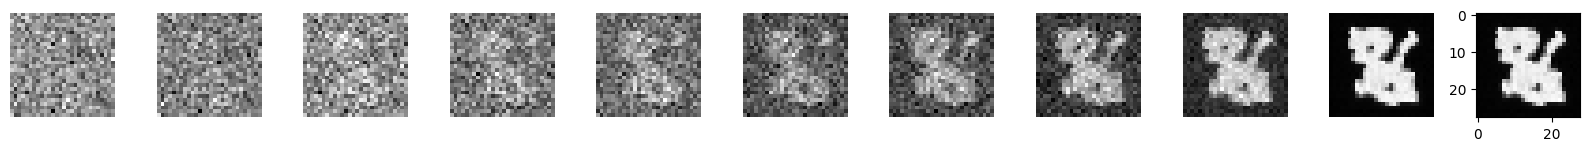

In [31]:
# train loop
model_hf = model_hf.to(device)
epochs = 50
optimizer = torch.optim.Adam(model_hf.parameters(), lr = 0.01)

for e in range(epochs) :

    for batch in train_loader :
        imgs = batch[0].to(device)
        # generate random noises
        z = torch.randn(imgs.size()).to(device)

        # sample time steps
        ts = torch.randint(0, noise_scheduler.num_train_timesteps, (len(imgs), ), device=device)

        # add noise to the images
        batch_noisy = noise_scheduler.add_noise(imgs, z, ts)

        pred_noise = model_hf(batch_noisy, ts)["sample"]
        loss = F.mse_loss(pred_noise, z)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('{} / {} : loss: {}'.format(e+1, epochs, loss))
        
    if (e%20 == 0) :
        label = torch.randint(0, 10, (1,))
        #print("generating num: ", label)
        img = sample_hf(model_hf, noise_scheduler)

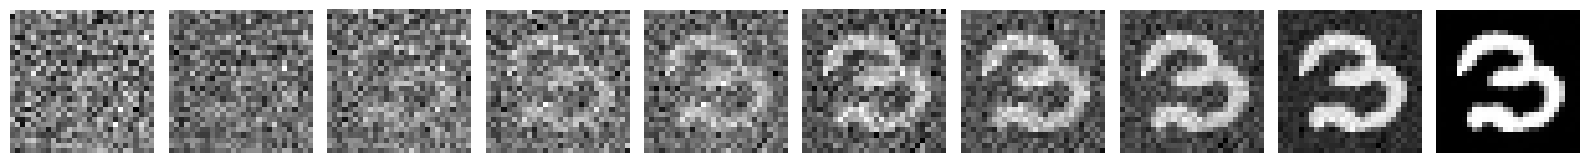

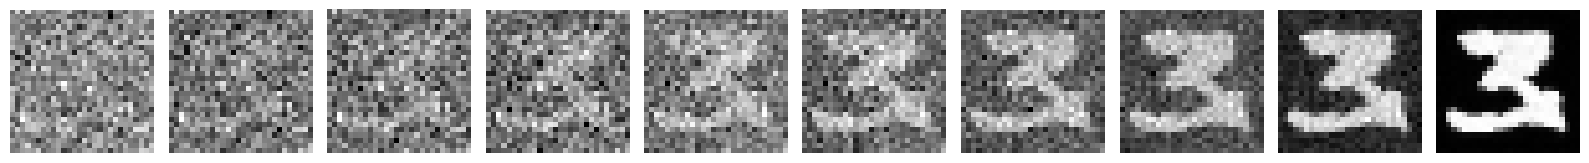

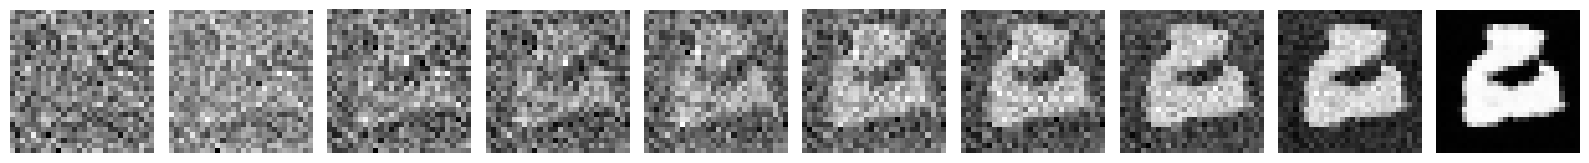

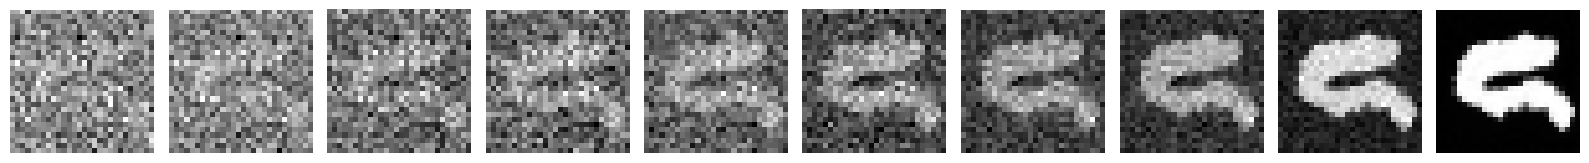

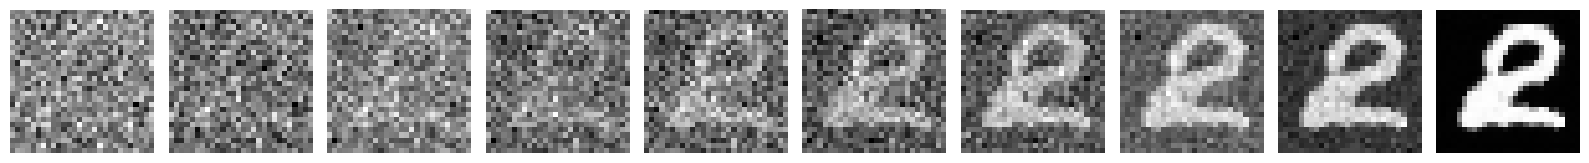

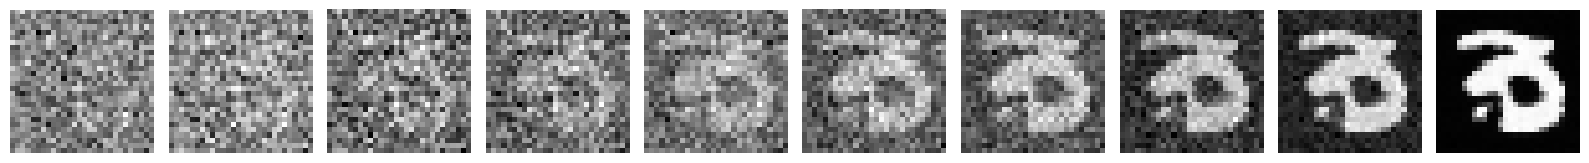

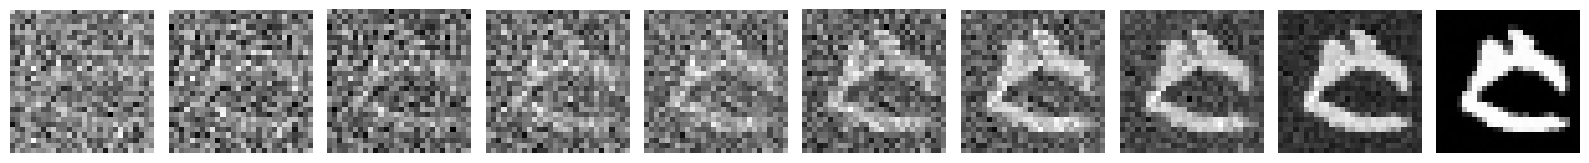

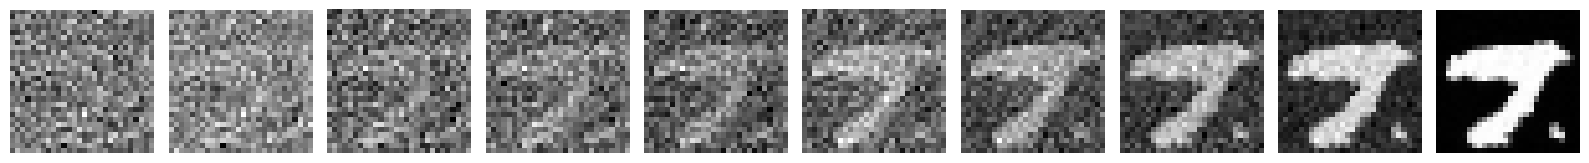

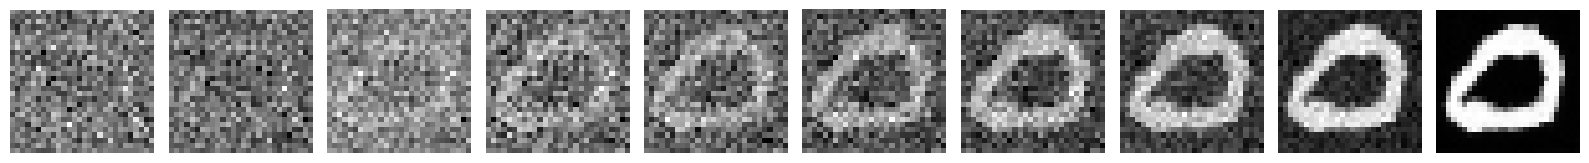

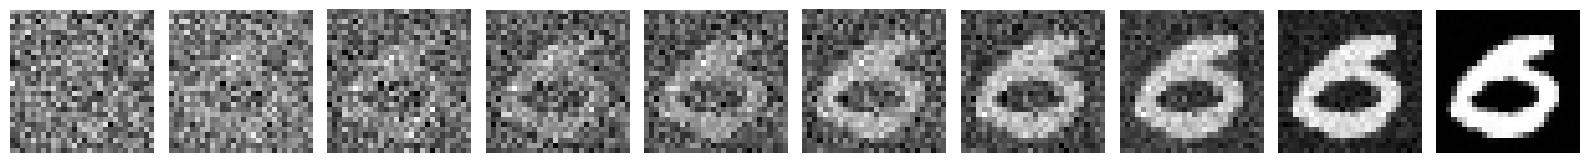

In [40]:
for i in range(10):
    sample_hf(model_hf,noise_scheduler)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model from scratch has: ", count_parameters(dm), "trainable parameters.")
print("Model from HF has: ", count_parameters(model_hf), "trainable parameters.")

Model from scratch has:  498425 trainable parameters.
Model from HF has:  636465 trainable parameters.


## Remark:
I used the similar net structure (but not exactly the same, only similar) using hugging face diffusion module and got similar results as my implementation from scratch. From my experience, those simple models of unet reached their learning capacity. 
Unet proved effective for generating applications, however, its training can be hard for:
 * it is sensitive to relu activation
 * loose learning capacity quickly even with more layers of convs.
For increase its capacity, I have tried to :
 * increase the conv layers (not realy helpful)
 * increase training epochs (not seems to approve, sometimes the results become worse)
 * increase the conv channels (not helpful)
 * add skip connections (seems to improve)
 * change from linear forward process to sinusoidal forward process (not helpful in this case)

In conclusion, the implementation of diffusion model is fairly easy. Unet is crucial for the generation quality.


reference:

 * https://www.youtube.com/watch?v=zEZOYZeIPUs&t=2s
 * https://www.youtube.com/watch?v=dbQCzrWgLh0
 * https://www.youtube.com/watch?v=BKfWc4Cmzpg&t=11s
 * https://arxiv.org/pdf/2209.00796.pdf
 * https://magic-with-latents.github.io/latent/posts/ddpms/part3/
 * https://www.youtube.com/watch?v=acxqoltilME
 * https://arxiv.org/pdf/2208.11970.pdf
 * https://huggingface.co/docs/diffusers/main/en/api/models
